In [145]:
import scipy.odr as so
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import optimize
from scipy.signal import butter, lfilter


In [4]:

#Linear function
def lin(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]



In [235]:
#Define the ADC, using the below parameters.

#random voltage uncertainty in V.
dV = 1/1000

#random sample time uncertainty in V. Note that this includes any uncertainty in timebase as well.
dt = 1

#Sampling rate in GHz
sr = 40

#Total length of the buffer in ps. This number definitely affects timing resolution, so keep an eye on it.
t_window = 1600

#The maximum voltage of the incoming signal in V.
v_range = 1
#If the incoming signal is linear, this is its slope, V/ps.
slope = 2/t_window*v_range
#Calibratable variation of timebase in ps
pvt_variation_sigma = 5
timebase = np.random.normal(0, pvt_variation_sigma, sr*t_window//1000) + np.linspace(0, t_window, sr*t_window//1000)

#Analog bandwidth of the LP filter applied before sampling in GHz. Note that this value has to be less than 1/2 of the sampling rate, otherwise the filtering will be disabled.
analog_bandwidth = 5

In [222]:
def generate_data(sr, dV, timebase, dt, t_window, V_range):
    #sr: sampling rate in GHz
    #t_zero: true temporal position of the pulse.
    result = np.zeros((sr*t_window//1000, 2))
    result[:, 0] = np.random.normal(0, dt, sr*t_window//1000) + timebase
    result[:, 1] = np.random.normal(0, dV, sr*t_window//1000) + np.linspace(0, t_window, sr*t_window//1000)*V_range/t_window
    return result

#Linear slope which starts abruptly from 0 at t_0.
def template_function(t, t_0, slope):
    return np.where(t<t_0, 0, slope*(t-t_0))

def generate_data_with_edge(sr, dV, timebase, dt, t_window, t_zero, V_range, analog_bandwidth):
    # Generates data that starts flat with <v> = 0. A slope starts at t_zero, increasing from zero up to V_range at the end of the window.
    #sr: sampling rate in GHz
    #t_window: length of the buffer in ps.
    #t_zero: true temporal position of the pulse in ps.
    result = np.zeros((sr*t_window//1000, 2))
    result[:, 0] = np.random.normal(0, dt, sr*t_window//1000) + timebase
    result[:, 1] = np.random.normal(0, dV, sr*t_window//1000) + butter_lowpass_filter(template_function(result[:, 0], t_zero, V_range / (t_window-t_zero)), analog_bandwidth, sr)
    return result

# Gaussian function
def gaussian(x, p):
    return p[0]*np.exp(-(x-p[1])**2/(2*p[2]**2))


def generate_data_gaussian(sr, dV, timebase, dt, t_window, t_zero, V_range, analog_bandwidth, temporal_width):
    # Generates data that starts flat with <v> = 0. A slope starts at t_zero, increasing from zero up to V_range at the end of the window.
    #sr: sampling rate in GHz
    #t_window: length of the buffer in ps.
    #t_zero: true temporal position of the pulse in ps.
    result = np.zeros((sr*t_window//1000, 2))
    result[:, 0] = np.random.normal(0, dt, sr*t_window//1000) + timebase
    result[:, 1] = np.random.normal(0, dV, sr*t_window//1000) + butter_lowpass_filter(gaussian(result[:, 0], (V_range, t_zero, temporal_width)), analog_bandwidth, sr)
    return result

#Slew is due to CMOS switch conductivity difference over input voltage, which does not exist in PSEC5. This function is therefore abandoned.
def slew(x, func, cutoff_freq):
    return (func(x)+func(x - 1000/cutoff_freq))/2
def generate_data_sine(sr, dV, timebase,  dt, t_window, t_zero, freq, V_range):
    # Generates data that starts flat with <v> = 0. A slope starts at t_zero, increasing from zero up to V_range at the end of the window.
    #sr: sampling rate in GHz
    #freq: sine frequency in GHz
    #t_window: length of the buffer in ps.
    #t_zero: true phase of the pulse in ps.
    result = np.zeros((sr*t_window//1000, 2))
    result[:, 0] = np.random.normal(0, dt, sr*t_window//1000) + timebase
    result[:, 1] = np.random.normal(0, dV, sr*t_window//1000) + (np.sin((result[:, 0]+t_zero)/1000*freq*2*np.pi)+1)/2*V_range
    return result
    


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

    

In [ ]:
#Timebase measurement is yet to be written.

Text(1000, 0.5, 'final dt = 0.14ps')

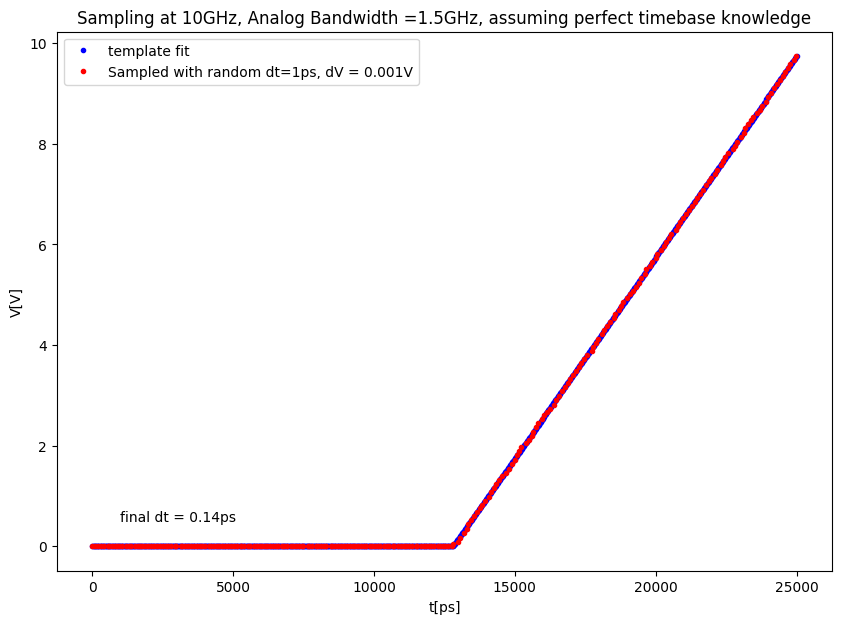

In [211]:
#Fit an infinitely rising edge.
raw_data = generate_data_with_edge(sr, dV, timebase, dt, t_window, t_window/2, v_range, analog_bandwidth)

fig,ax = plt.subplots(figsize=(10,7))


#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = 1/slope
result = optimize.curve_fit(lambda x, x_0: template_function(x,x_0, slope), timebase, raw_data[:,1], p_0)
X = np.linspace(0, t_window, 1000)
ax.plot(X ,template_function(X, result[0], 1/p_0), 'b.', label='template fit')
ax.plot(timebase ,raw_data[:,1], 'r.', label='Sampled with random dt='+str(dt)+'ps, dV = '+str(dV)+'V')
ax.set_xlabel("t[ps]")
ax.set_ylabel("V[V]")
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 1])
ax.set_title("Sampling at "+str(sr)+"GHz, Analog Bandwidth ="+str(analog_bandwidth)+"GHz, assuming perfect timebase knowledge")
ax.legend()

t_zero_estimate = []
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = 1/slope
for i in range(10000):
    raw_data = generate_data_with_edge(sr, dV, timebase, dt, t_window, t_window/2, v_range, analog_bandwidth)
    result = optimize.curve_fit(lambda x, x_0: template_function(x,x_0, slope), timebase, raw_data[:,1], p_0)
    t_zero_estimate.append(result[0][0])

# Final Delta T of known rising edge template fitting.
ax.annotate('final dt = '+str(np.std(np.array(t_zero_estimate)))[0:4]+'ps', (1000, 0.5))

Text(100, 0.4, 'Sigma of gaussian pulse = 300ps')

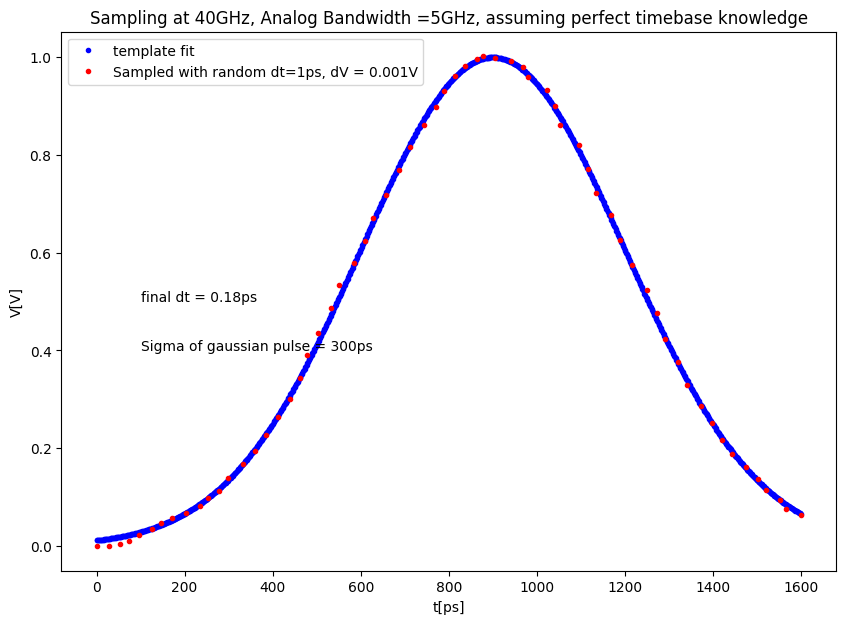

In [236]:
#Fit a gaussian.
# Width of the pulse in ps.
pulse_width = 300
raw_data = generate_data_gaussian(sr, dV, timebase, dt, t_window, t_window/2, v_range, analog_bandwidth, pulse_width)

fig,ax = plt.subplots(figsize=(10,7))


#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = t_window/2
result = optimize.curve_fit(lambda x, x_0: gaussian(x,(v_range, x_0, pulse_width)), timebase, raw_data[:,1], p_0)
X = np.linspace(0, t_window, 1000)
ax.plot(X ,gaussian(X,(v_range, result[0], pulse_width)), 'b.', label='template fit')
ax.plot(timebase ,raw_data[:,1], 'r.', label='Sampled with random dt='+str(dt)+'ps, dV = '+str(dV)+'V')
ax.set_xlabel("t[ps]")
ax.set_ylabel("V[V]")
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 1])
ax.set_title("Sampling at "+str(sr)+"GHz, Analog Bandwidth ="+str(analog_bandwidth)+"GHz, assuming perfect timebase knowledge")
ax.legend()

t_zero_estimate = []
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = t_window/2
for i in range(10000):
    raw_data = generate_data_gaussian(sr, dV, timebase, dt, t_window, t_window/2, v_range, analog_bandwidth, pulse_width)
    result = optimize.curve_fit(lambda x, x_0: gaussian(x,(v_range, x_0, pulse_width)), timebase, raw_data[:,1], p_0)
    t_zero_estimate.append(result[0][0])

# Final Delta T of known rising edge template fitting.
ax.annotate('final dt = '+str(np.std(np.array(t_zero_estimate)))[0:4]+'ps', (100, 0.5))
ax.annotate('Sigma of gaussian pulse = '+str(pulse_width)[0:4]+'ps', (100, 0.4))

Text(0, 0, 'final dt = 3.79ps')

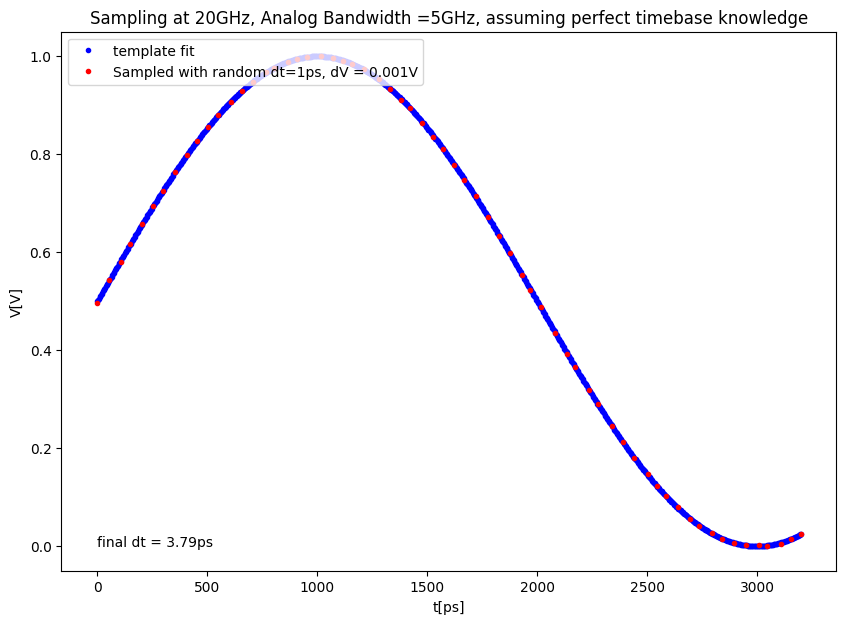

In [234]:
#Fit a sine wave.
def sine(x, x_0, freq):
    return (np.sin((x+x_0)*2*np.pi*freq / 1000)+1)/2

#Frequency of the sine wave in GHz.
freq = 0.25
raw_data = generate_data_sine(sr, dV, timebase, dt, t_window, 0, freq, 1.0)

fig,ax = plt.subplots(figsize=(10,7))


#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = 0
result = optimize.curve_fit(lambda x, x_0: sine(x,x_0, freq), timebase, raw_data[:,1], p_0)
X = np.linspace(0, t_window, 1000)
ax.plot(X ,sine(X, result[0], freq), 'b.', label='template fit')
ax.plot(timebase ,raw_data[:,1], 'r.', label='Sampled with random dt='+str(dt)+'ps, dV = '+str(dV)+'V')
ax.set_xlabel("t[ps]")
ax.set_ylabel("V[V]")
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 1])
ax.set_title("Sampling at "+str(sr)+"GHz, Analog Bandwidth ="+str(analog_bandwidth)+"GHz, assuming perfect timebase knowledge")
ax.legend(loc= 'upper left')

t_zero_estimate = []
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
p_0 = 0
for i in range(10000):
    raw_data = generate_data_sine(sr, dV, timebase, dt, t_window, 0, freq, 1.0)
    result = optimize.curve_fit(lambda x, x_0: sine(x,x_0, slope), freq, raw_data[:,1], p_0, bounds = (-100, 100))
    t_zero_estimate.append(result[0][0])

# Final Delta T of known rising edge template fitting.
ax.annotate('final dt = '+str(np.std(np.array(t_zero_estimate)))[0:4]+'ps', (0, 0))

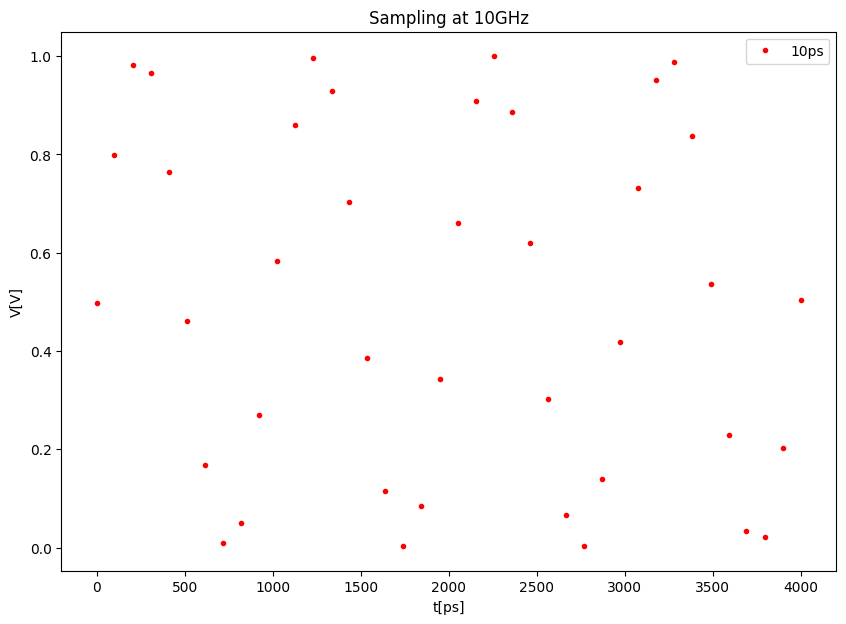

In [34]:
dV = 1/1000
dt = 1.0
raw_data = generate_data_sine(10, dV, dt, 4000, 0, 1, 1.0)
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(raw_data[:,0] ,raw_data[:,1], 'r.', label='10ps')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("t[ps]")
ax.set_ylabel("V[V]")
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 1])
ax.set_title("Sampling at 10GHz")
ax.legend()

Rest of the code is Orthogonal Distance Regression (ODR) on a linear function. It is no longer useful.

In [ ]:
linear = so.Model(lin)



dVlist = np.geomspace(1/(2**4), 1/(2**16), 13)
taulist10 = []
dt = 10.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(10, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist10.append(np.std(list))

In [7]:
linear = so.Model(lin)

dV = 1e-3

dVlist = np.geomspace(1/(2**4), 1/(2**16), 13)

dt = 10.0
N = 10000
list = np.zeros(N)
for i in range(N):
    raw_data = generate_data(10, dV, dt, 1000, 1.0)
    mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

    myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

    myoutput = myodr.run()
    list[i] = myoutput.beta[1]/myoutput.beta[0]
print(np.std(list))

5.903729451661434


In [57]:
linear = so.Model(lin)



dVlist = np.geomspace(1/(2**4), 1/(2**16), 13)
taulist10 = []
dt = 10.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(10, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist10.append(np.std(list))

In [58]:
linear = so.Model(lin)



dVlist = np.geomspace(1/(2**4), 1/(2**16), 13)
taulist5 = []
dt = 5.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(10, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist5.append(np.std(list))

In [59]:
linear = so.Model(lin)



dVlist = np.geomspace(1/(2**4), 1/(2**16), 13)
taulist2 = []
dt = 2.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(10, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2.append(np.std(list))

(0.0, 10.0)

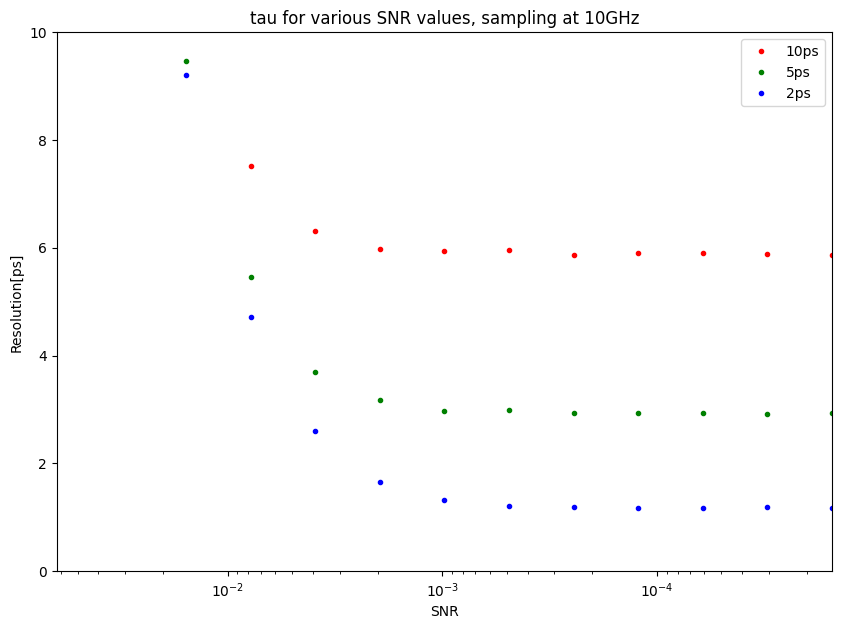

In [73]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(dVlist ,taulist10, 'r.', label='10ps')
ax.plot(dVlist ,taulist5, 'g.', label='5ps')
ax.plot(dVlist ,taulist2, 'b.', label='2ps')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("SNR")
ax.set_ylabel("Resolution[ps]")
ax.set_xlim([0, 1024])
ax.set_ylim([0, 500])
ax.set_title("tau for various SNR values, sampling at 10GHz")
ax.annotate("Barium K line", xy=(50, 400), xytext=(200, 400),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Compton shelf", xy=(300, 100), xytext=(300, 200),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Backscatter", xy=(140, 200), xytext=(200, 200),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("662keV peak", xy=(450, 200), xytext=(500, 200),
            arrowprops=dict(arrowstyle="->"))
ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
ax.set_xlim([1/(2**4), 1/(2**16)])
ax.set_ylim([0, 10])

In [15]:
dVlist = np.geomspace(1/(2**4), 1/(2**16), 26)
taulist10_40G = []
dt = 10.0
for dV in dVlist:
    N = 20000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(40, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist10_40G.append(np.std(list))

taulist5_40G = []
dt = 5.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(40, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist5_40G.append(np.std(list))
    
taulist2_40G = []
dt = 2.0
for dV in dVlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(40, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2_40G.append(np.std(list))

(0.0, 5.0)

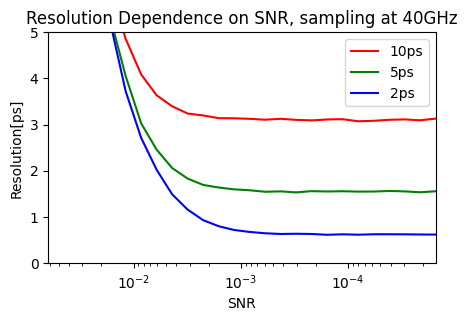

In [16]:
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(dVlist ,taulist10_40G, 'r-', label='10ps')
ax.plot(dVlist ,taulist5_40G, 'g-', label='5ps')
ax.plot(dVlist ,taulist2_40G, 'b-', label='2ps')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("SNR")
ax.set_ylabel("Resolution[ps]")
ax.set_xlim([0, 1024])
ax.set_ylim([0, 500])
ax.set_title("Resolution Dependence on SNR, sampling at 40GHz")
ax.annotate("Barium K line", xy=(50, 400), xytext=(200, 400),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Compton shelf", xy=(300, 100), xytext=(300, 200),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Backscatter", xy=(140, 200), xytext=(200, 200),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("662keV peak", xy=(450, 200), xytext=(500, 200),
            arrowprops=dict(arrowstyle="->"))
ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
ax.set_xlim([1/(2**4), 1/(2**16)])
ax.set_ylim([0, 5])

In [3]:
srlist = np.array([1,2,3, 4,6, 8,10, 15,20, 30,40, 50])
taulist10_SR = []
dt = 10.0
dV = 1e-3
for sr in srlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist10_SR.append(np.std(list))

taulist5_SR = []
dt = 5.0
dV = 1e-3
for sr in srlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist5_SR.append(np.std(list))
    
taulist2_SR = []
dt = 2.0
dV = 1e-3
for sr in srlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2_SR.append(np.std(list))

NameError: name 'generate_data' is not defined

(0.0, 10.0)

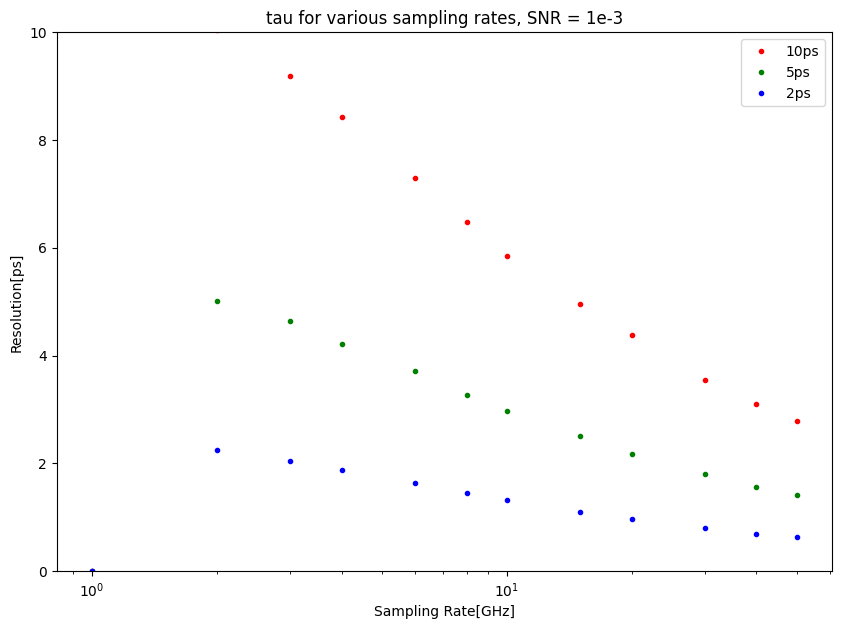

In [86]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(srlist ,taulist10_SR, 'r.', label='10ps')
ax.plot(srlist ,taulist5_SR, 'g.', label='5ps')
ax.plot(srlist ,taulist2_SR, 'b.', label='2ps')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("Sampling Rate[GHz]")
ax.set_ylabel("Resolution[ps]")
ax.set_title("tau for various sampling rates, SNR = 1e-3")

ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
#ax.set_xlim([1,50])
ax.set_ylim([0, 10])

In [8]:
dtlist = np.geomspace(0.5, 10, 20)
taulisti_SR10 = []
sr = 10
dV = 1e-3
for dt in dtlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulisti_SR10.append(np.std(list))

taulisti_SR20 = []
sr = 20
dV = 1e-3
for dt in dtlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulisti_SR20.append(np.std(list))
    
taulisti_SR40 = []
sr = 40
dV = 1e-3
for dt in dtlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(sr, dV, dt, 1000, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulisti_SR40.append(np.std(list))

(0.0, 5.0)

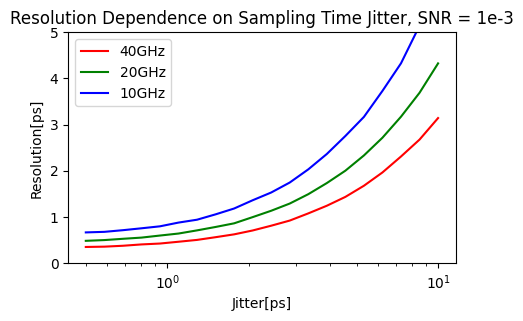

In [12]:
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(dtlist ,taulisti_SR40, 'r-', label='40GHz')
ax.plot(dtlist ,taulisti_SR20, 'g-', label='20GHz')
ax.plot(dtlist ,taulisti_SR10, 'b-', label='10GHz')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("Jitter[ps]")
ax.set_ylabel("Resolution[ps]")
ax.set_title("Resolution Dependence on Sampling Time Jitter, SNR = 1e-3")

ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
#ax.set_xlim([1,50])
ax.set_ylim([0, 5])

In [102]:

taulist2_SR10_freq = []
sr = 10
dV = 1e-3
dt = 2
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2_SR10_freq.append(np.std(list))

taulist2_SR20_freq = []
sr = 20
dV = 1e-3
dt = 2
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2_SR20_freq.append(np.std(list))

taulist2_SR40_freq = []
sr = 40
dV = 1e-3
dt = 2
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist2_SR40_freq.append(np.std(list))

(0.0, 2.0)

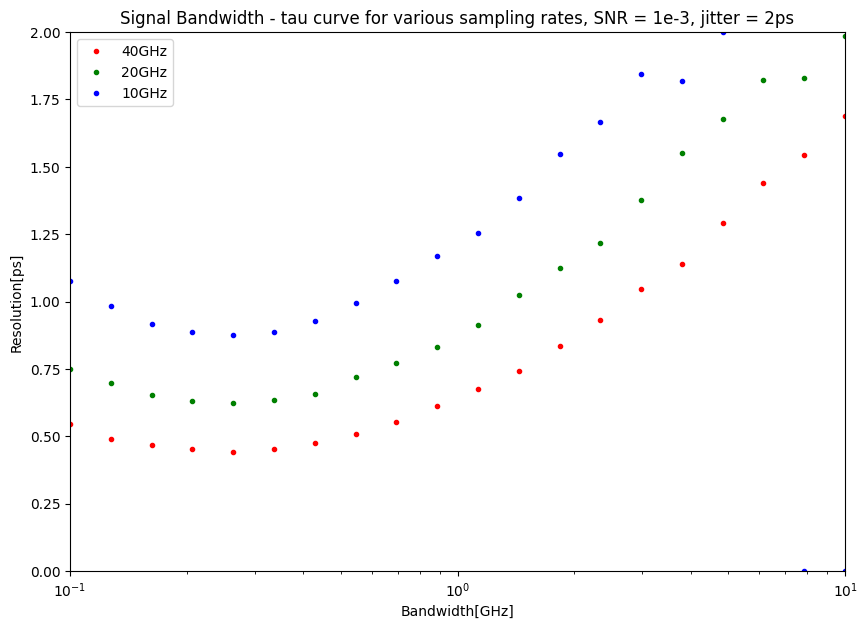

In [95]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(freqlist ,taulist2_SR40_freq, 'r.', label='40GHz')
ax.plot(freqlist ,taulist2_SR20_freq, 'g.', label='20GHz')
ax.plot(freqlist ,taulist2_SR10_freq, 'b.', label='10GHz')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("Bandwidth[GHz]")
ax.set_ylabel("Resolution[ps]")
ax.set_title("Signal Bandwidth - tau curve for various sampling rates, SNR = 1e-3, jitter = 2ps")

ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
ax.set_xlim([0.1, 10])
ax.set_ylim([0, 2])

In [99]:
taulist1_SR10_freq = []
sr = 10
dV = 1e-3
dt = 1
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist1_SR10_freq.append(np.std(list))

taulist1_SR20_freq = []
sr = 20
dV = 1e-3
dt = 1
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist1_SR20_freq.append(np.std(list))

taulist1_SR40_freq = []
sr = 40
dV = 1e-3
dt = 1
freqlist = np.geomspace(0.1, 10, 20)
for freq in freqlist:
    N = 10000
    list = np.zeros(N)
    for i in range(N):
        raw_data = generate_data(round(sr / freq), dV, dt, 500/freq, 1.0)
        mydata = so.RealData(raw_data[:,0], raw_data[:,1], sx=dt, sy=dV)

        myodr = so.ODR(mydata, linear, beta0=[1e-3, 0])

        myoutput = myodr.run()
        list[i] = myoutput.beta[1]/myoutput.beta[0]
    taulist1_SR40_freq.append(np.std(list))

(0.0, 1.0)

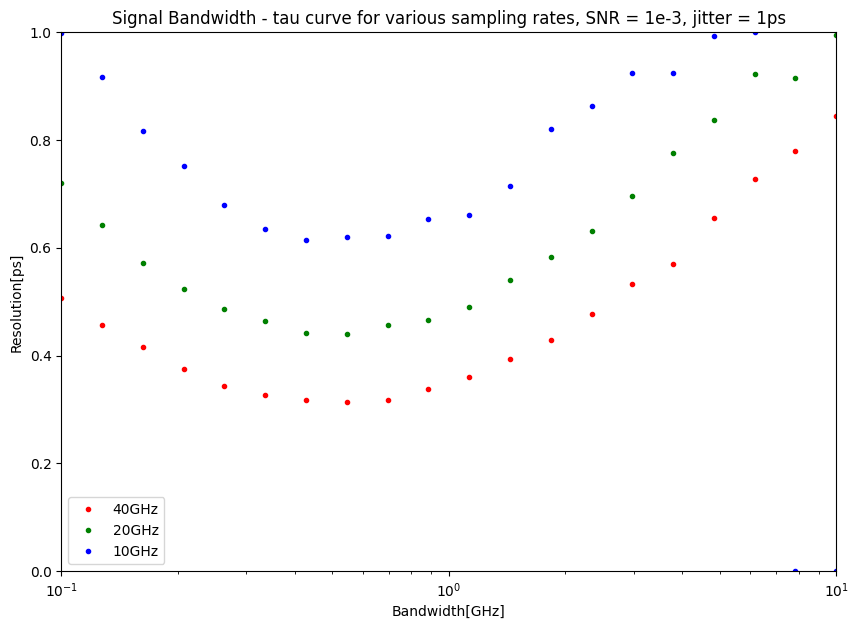

In [101]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(freqlist ,taulist1_SR40_freq, 'r.', label='40GHz')
ax.plot(freqlist ,taulist1_SR20_freq, 'g.', label='20GHz')
ax.plot(freqlist ,taulist1_SR10_freq, 'b.', label='10GHz')
#p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
#ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
#ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("Bandwidth[GHz]")
ax.set_ylabel("Resolution[ps]")
ax.set_title("Signal Bandwidth - tau curve for various sampling rates, SNR = 1e-3, jitter = 1ps")

ax.legend()

ax.set_xscale('log')
#ax.set_xticks( [0,1,2,3,4,] )
ax.set_xlim([0.1, 10])
ax.set_ylim([0, 1])